In [ ]:
!ls /content/drive/MyDrive


 0-17527957255_20210227_140450_0000.pdf
 16082021074835-uxz.pdf
 17082021075648-uxz.pdf
'AI-Powered Early Warning Dashboard'
'Ans_Key_COMPONENTS & PRESERVATIVES (1).pdf'
'Ans_Key_COMPONENTS & PRESERVATIVES.pdf'
'blog writing examples.pdf'
'certificate (6) (2) (1).pdf'
'certificate (6) (2).pdf'
'certificate (7) (1) (1).pdf'
'certificate (7) (1) (2).pdf'
'certificate (7) (1) (3).pdf'
'certificate (7) (1) (4).pdf'
'certificate (7) (1).pdf'
'CH-5 STATES OF MATTER NOTES (1).pdf'
'CH-5 STATES OF MATTER NOTES (2).pdf'
'CH-5 STATES OF MATTER NOTES.pdf'
'CIRCULAR IV-TERM 1.pdf'
 Classroom
'Class Test Time Table Gr. IV.pdf'
 CoralHealthClassifier
'critical appreciation and summary of the sower poem.pdf'
'critical appreciation of poem nose versus eyes.pdf'
'Deepa Vaccination Certificate.pdf'
'EDTA Obs n Cal.docx1'
'expansion of ideas format and examples.pdf'
'film review format.pdf'
 Globesetter
'Grade-4 Worksheet L-5& 6.pdf'
'Grade-4 Worksheet L-7 &8.pdf'
 Images
'interview questions format and 

In [ ]:
!unzip -q "/content/drive/MyDrive/LYProject/SkinCondition.zip" -d "/content/"


In [ ]:
!unzip -oq "/content/drive/MyDrive/LYProject/SkinCondition.zip" -d "/content/"




In [ ]:
data_dir = "/content/DATA"



In [ ]:
!ls /content/DATA


test  train  val


In [ ]:
# ======================================================
# Step 1: Setup (Mount Drive, Install packages)
# ======================================================
from google.colab import drive
drive.mount('/content/drive')

!pip install torch torchvision timm scikit-learn tqdm

# ======================================================
# Step 2: Unzip your dataset into /content/
# ======================================================
!rm -rf /content/DATA
!unzip -oq "/content/drive/MyDrive/LYProject/SkinCondition.zip" -d "/content/"

# Check dataset structure
!ls /content/DATA
!ls /content/DATA/train

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
test  train  val
 acne   Eczema	 Psoriasis  'Tinea Ringworm'


In [ ]:
# ======================================================
# Step 3: Training script
# ======================================================
import os, random
import numpy as np
from collections import Counter
from tqdm import tqdm
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import transforms, datasets, models
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# ------------------------------
# Reproducibility
# ------------------------------
def seed_everything(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
seed_everything()

# ------------------------------
# MixUp helper
# ------------------------------
def mixup_data(x, y, alpha=0.4, device='cpu'):
    if alpha <= 0: return x, y, None, 1.0
    lam = np.random.beta(alpha, alpha)
    index = torch.randperm(x.size(0)).to(device)
    return lam*x + (1-lam)*x[index], y, y[index], lam

def mixup_criterion(criterion, preds, y_a, y_b, lam):
    return lam * criterion(preds, y_a) + (1 - lam) * criterion(preds, y_b)

# ------------------------------
# Data Loaders
# ------------------------------
def build_loaders(data_dir, img_size=224, batch_size=32):
    train_tfms = transforms.Compose([
        transforms.RandomResizedCrop(img_size, scale=(0.7,1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(0.2,0.2,0.2,0.02),
        transforms.RandomRotation(20),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ])
    val_tfms = transforms.Compose([
        transforms.Resize(int(img_size*1.14)),
        transforms.CenterCrop(img_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ])

    train_ds = datasets.ImageFolder(os.path.join(data_dir,'train'), transform=train_tfms)
    val_ds   = datasets.ImageFolder(os.path.join(data_dir,'val'), transform=val_tfms)
    test_ds  = datasets.ImageFolder(os.path.join(data_dir,'test'), transform=val_tfms)

    # Weighted sampler for imbalance
    targets = [s[1] for s in train_ds.samples]
    class_counts = Counter(targets)
    weights = [1.0/class_counts[t] for t in targets]
    sampler = WeightedRandomSampler(weights, len(train_ds))

    train_loader = DataLoader(train_ds, batch_size=batch_size, sampler=sampler, num_workers=2)
    val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2)
    test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2)
    return train_loader, val_loader, test_loader, train_ds.classes

# ------------------------------
# Model (MobileNetV2)
# ------------------------------
def build_model(num_classes):
    model = models.mobilenet_v2(pretrained=True)
    in_f = model.classifier[1].in_features
    model.classifier = nn.Sequential(
        nn.Dropout(0.2),
        nn.Linear(in_f, num_classes)
    )
    return model

# ------------------------------
# Training loop
# ------------------------------
def train_one_epoch(model, loader, optimizer, device, criterion, mixup_alpha=0.4):
    model.train()
    total_loss, y_true, y_pred = 0, [], []
    for imgs, labels in tqdm(loader, leave=False):
        imgs, labels = imgs.to(device), labels.to(device)
        imgs, y_a, y_b, lam = mixup_data(imgs, labels, alpha=mixup_alpha, device=device)
        out = model(imgs)
        loss = mixup_criterion(criterion, out, y_a, y_b, lam)
        optimizer.zero_grad(); loss.backward(); optimizer.step()
        total_loss += loss.item()*imgs.size(0)
        y_true.extend(labels.cpu().numpy()); y_pred.extend(out.argmax(1).cpu().numpy())
    return total_loss/len(loader.dataset), accuracy_score(y_true,y_pred)

@torch.no_grad()
def evaluate(model, loader, device, criterion=None):
    model.eval(); total_loss=0; y_true=[]; y_pred=[]
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        out = model(imgs)
        if criterion: total_loss += criterion(out,labels).item()*imgs.size(0)
        y_true.extend(labels.cpu().numpy()); y_pred.extend(out.argmax(1).cpu().numpy())
    return (total_loss/len(loader.dataset) if criterion else None), accuracy_score(y_true,y_pred), y_true, y_pred

# ======================================================
# Step 4: Train
# ======================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

data_dir = "/content/DATA"   # ✅ your dataset path
train_loader, val_loader, test_loader, classes = build_loaders(data_dir, img_size=224, batch_size=32)
print("Classes:", classes)

model = build_model(len(classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

best_acc = 0
for epoch in range(1, 21):
    tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, device, criterion)
    val_loss, val_acc, _, _ = evaluate(model, val_loader, device, criterion)
    scheduler.step()
    print(f"Epoch {epoch}: Train Acc {tr_acc:.4f}, Val Acc {val_acc:.4f}")
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "/content/drive/MyDrive/mobilenet_best.pth")
        print("✅ Saved new best model")

# ======================================================
# Step 5: Evaluate on test set
# ======================================================
model.load_state_dict(torch.load("/content/drive/MyDrive/mobilenet_best.pth"))
test_loss, test_acc, y_true, y_pred = evaluate(model, test_loader, device, criterion)
print("Test Accuracy:", test_acc)

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=classes, digits=4))
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Using device: cuda
Classes: ['Eczema', 'Psoriasis', 'Tinea Ringworm', 'acne']
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 76.7MB/s]


Epoch 1: Train Acc 0.4515, Val Acc 0.6501
✅ Saved new best model


Epoch 2: Train Acc 0.4458, Val Acc 0.6998
✅ Saved new best model


Epoch 3: Train Acc 0.4641, Val Acc 0.6988


Epoch 4: Train Acc 0.5401, Val Acc 0.7170
✅ Saved new best model


Epoch 5: Train Acc 0.5173, Val Acc 0.7475
✅ Saved new best model


Epoch 6: Train Acc 0.5340, Val Acc 0.7475


Epoch 7: Train Acc 0.5455, Val Acc 0.7414


Epoch 8: Train Acc 0.5653, Val Acc 0.7414


Epoch 9: Train Acc 0.5768, Val Acc 0.7505
✅ Saved new best model


Epoch 10: Train Acc 0.5855, Val Acc 0.7708
✅ Saved new best model


Epoch 11: Train Acc 0.5592, Val Acc 0.7911
✅ Saved new best model


Epoch 12: Train Acc 0.6298, Val Acc 0.7759


Epoch 13: Train Acc 0.5978, Val Acc 0.7748


Epoch 14: Train Acc 0.5787, Val Acc 0.7830


Epoch 15: Train Acc 0.5798, Val Acc 0.7931
✅ Saved new best model


Epoch 16: Train Acc 0.5846, Val Acc 0.7921


Epoch 17: Train Acc 0.5983, Val Acc 0.7941
✅ Saved new best model


Epoch 18: Train Acc 0.5787, Val Acc 0.7972
✅ Saved new best model


Epoch 19: Train Acc 0.5828, Val Acc 0.7931


Epoch 20: Train Acc 0.6376, Val Acc 0.7921
Test Accuracy: 0.8012108980827447
Classification Report:
                precision    recall  f1-score   support

        Eczema     0.7240    0.7984    0.7594       253
     Psoriasis     0.7743    0.7217    0.7471       309
Tinea Ringworm     0.7903    0.7656    0.7778       256
          acne     0.9830    1.0000    0.9914       173

      accuracy                         0.8012       991
     macro avg     0.8179    0.8214    0.8189       991
  weighted avg     0.8020    0.8012    0.8008       991

Confusion Matrix:
[[202  28  22   1]
 [ 54 223  30   2]
 [ 23  37 196   0]
 [  0   0   0 173]]


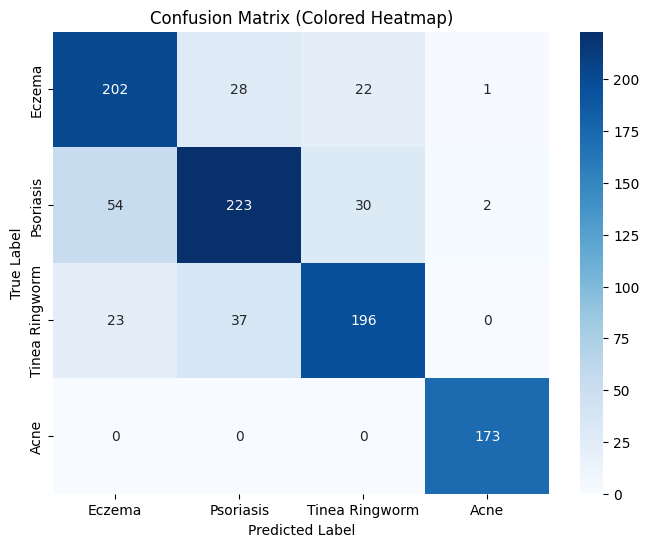

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Compute confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)

# Define class names
class_names = ["Eczema", "Psoriasis", "Tinea Ringworm", "Acne"]

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Colored Heatmap)")
plt.show()



In [ ]:
import pickle

# Save
with open("/content/drive/MyDrive/LYProject/mobilenet_best.pkl", "wb") as f:
    pickle.dump(model, f)

# Load back later
with open("/content/drive/MyDrive/LYProject/mobilenet_best.pkl", "rb") as f:
    model_loaded = pickle.load(f)